# Install & Import Dependencies

In [1]:
!pip install ipython-autotime -q
%load_ext autotime

time: 499 µs (started: 2025-01-28 10:41:31 +00:00)


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

time: 813 µs (started: 2025-01-28 11:07:41 +00:00)


# Load Dataset

In [3]:
url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/spiill_reviews_preprocessed.csv'
df_reviews = pd.read_csv(url)
df_reviews.tail(3)

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
5898,eiswahyudi,3,2024-03-17,non,neutral,Pasar saham Indonesia menunjukkan tren yang st...,Masker Skintific,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,pasar saham indonesia menunjukkan tren yang st...,"['pasar', 'saham', 'indonesia', 'menunjukkan',...","['pasar', 'saham', 'indonesia', 'tren', 'stabil']","['pasar', 'saham', 'indonesia', 'tren', 'stabil']","['pasar', 'saham', 'indonesia', 'tren', 'stabil']"
5899,dkusumo,5,2023-09-18,non,neutral,Penggunaan kendaraan listrik mulai diminati di...,Masker Skintific,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,penggunaan kendaraan listrik mulai diminati di...,"['penggunaan', 'kendaraan', 'listrik', 'mulai'...","['penggunaan', 'kendaraan', 'listrik', 'dimina...","['penggunaan', 'kendaraan', 'listrik', 'dimina...","['guna', 'kendara', 'listrik', 'mati', 'kota']"
5900,adisti,3,2023-09-11,non,neutral,Lumayan lancar dengan berjalan baik,Masker Skintific,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,lumayan lancar dengan berjalan baik,"['lumayan', 'lancar', 'dengan', 'berjalan', 'b...","['lumayan', 'lancar', 'berjalan']","['lumayan', 'lancar', 'berjalan']","['lumayan', 'lancar', 'jalan']"


time: 801 ms (started: 2025-01-28 10:42:00 +00:00)


In [4]:
df_reviews.sentimen.value_counts()

sentimen
positive    3687
neutral     1352
negative     862
Name: count, dtype: int64

time: 6.88 ms (started: 2025-01-28 10:42:01 +00:00)


In [5]:
df_reviews.label.value_counts()

label
trusted    3912
non        1150
fake        839
Name: count, dtype: int64

time: 15.7 ms (started: 2025-01-28 10:42:01 +00:00)


# Modeling

## Model Function Preparation

In [6]:
# Preprocessing functions
def preprocess_data(df):
    # Convert string representations of lists to actual lists
    def safe_eval(x):
        try:
            if isinstance(x, list):
                return x
            elif isinstance(x, str):
                if x.startswith('[') and x.endswith(']'):
                    return eval(x)
                else:
                    return x.split()
            return []
        except:
            return x.split() if isinstance(x, str) else []

    df['stemmed_reviews'] = df['stemmed_reviews'].apply(safe_eval)
    
    # Create text sequences
    texts = df['stemmed_reviews'].tolist()
    
    # Train Word2Vec model
    word2vec_model = Word2Vec(texts, vector_size=100, window=5, min_count=1, workers=4)
    
    # Create tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    # Create embedding matrix
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, 100))
    
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    
    return padded_sequences, embedding_matrix, vocab_size, max_len, tokenizer

# Create model
def create_multitask_model(vocab_size, embedding_matrix, max_len):
    # Input layer
    input_layer = Input(shape=(max_len,))
    
    # Embedding layer with pre-trained weights
    embedding_layer = Embedding(
        vocab_size,
        100,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )(input_layer)
    
    # BiLSTM layer
    bilstm = Bidirectional(LSTM(100, return_sequences=True))(embedding_layer)
    
    # Global Max Pooling
    pooling = GlobalMaxPooling1D()(bilstm)
    
    # Shared layers
    shared = Dropout(0.5)(pooling)
    shared = Dense(128, activation='relu')(shared)
    shared = Dropout(0.5)(shared)
    
    # Output layers
    sentiment_output = Dense(3, activation='softmax', name='sentiment')(shared)
    label_output = Dense(3, activation='softmax', name='label')(shared)
    
    # Create model
    model = Model(
        inputs=input_layer,
        outputs=[sentiment_output, label_output]
    )
    
    # Initialize AdamW optimizer with learning rate
    optimizer = AdamW(learning_rate=1e-4)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss={
            'sentiment': 'categorical_crossentropy',
            'label': 'categorical_crossentropy'
        },
        metrics={
            'sentiment': 'accuracy',
            'label': 'accuracy'
        }
    )
    
    return model

# Main execution
def train_model(df):
    # Preprocess text data
    X, embedding_matrix, vocab_size, max_len, tokenizer = preprocess_data(df)
    
    # Prepare labels
    sentiment_encoder = LabelEncoder()
    label_encoder = LabelEncoder()
    
    y_sentiment = sentiment_encoder.fit_transform(df['sentimen'])
    y_label = label_encoder.fit_transform(df['label'])
    
    # Convert to categorical
    y_sentiment = tf.keras.utils.to_categorical(y_sentiment)
    y_label = tf.keras.utils.to_categorical(y_label)
    
    # Split data
    X_train, X_test, y_sentiment_train, y_sentiment_test, y_label_train, y_label_test = train_test_split(
        X, y_sentiment, y_label, test_size=0.2, random_state=42
    )
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        mode='min'
    )
    
    # Create and train model
    model = create_multitask_model(vocab_size, embedding_matrix, max_len)
    
    history = model.fit(
        X_train,
        {
            'sentiment': y_sentiment_train,
            'label': y_label_train
        },
        validation_data=(
            X_test,
            {
                'sentiment': y_sentiment_test,
                'label': y_label_test
            }
        ),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return (model, history, sentiment_encoder, label_encoder, tokenizer, max_len, 
            X_test, y_sentiment_test, y_label_test)

# Function to make predictions
def predict_text(text, model, tokenizer, sentiment_encoder, label_encoder, max_len):
    # Preprocess input text
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    
    # Make prediction
    sentiment_pred, label_pred = model.predict(padded)
    
    # Convert predictions to classes
    sentiment = sentiment_encoder.inverse_transform([np.argmax(sentiment_pred[0])])[0]
    label = label_encoder.inverse_transform([np.argmax(label_pred[0])])[0]
    
    return sentiment, label

# Function to evaluate model and display metrics
def evaluate_model(model, X_test, y_sentiment_test, y_label_test, sentiment_encoder, label_encoder):
    # Get predictions
    sentiment_pred, label_pred = model.predict(X_test)
    
    # Convert predictions to class labels
    sentiment_pred_classes = np.argmax(sentiment_pred, axis=1)
    label_pred_classes = np.argmax(label_pred, axis=1)
    
    sentiment_true_classes = np.argmax(y_sentiment_test, axis=1)
    label_true_classes = np.argmax(y_label_test, axis=1)
    
    # Get original class names
    sentiment_classes = sentiment_encoder.classes_
    label_classes = label_encoder.classes_
    
    # Print Classification Reports
    print("\nSentiment Classification Report:")
    print(classification_report(sentiment_true_classes, sentiment_pred_classes, 
                              target_names=sentiment_classes))
    
    print("\nLabel Classification Report:")
    print(classification_report(label_true_classes, label_pred_classes, 
                              target_names=label_classes))
    
    # Create Confusion Matrices
    def plot_confusion_matrix(true_classes, pred_classes, classes, title):
        cm = confusion_matrix(true_classes, pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    # Plot Confusion Matrices
    plot_confusion_matrix(sentiment_true_classes, sentiment_pred_classes, 
                         sentiment_classes, 'Sentiment Confusion Matrix')
    plot_confusion_matrix(label_true_classes, label_pred_classes, 
                         label_classes, 'Label Confusion Matrix')
    
    return {
        'sentiment_report': classification_report(sentiment_true_classes, 
                                                sentiment_pred_classes, 
                                                target_names=sentiment_classes, 
                                                output_dict=True),
        'label_report': classification_report(label_true_classes, 
                                            label_pred_classes, 
                                            target_names=label_classes, 
                                            output_dict=True),
        'sentiment_cm': confusion_matrix(sentiment_true_classes, sentiment_pred_classes),
        'label_cm': confusion_matrix(label_true_classes, label_pred_classes)
    }

time: 3.6 ms (started: 2025-01-28 10:42:01 +00:00)


## Train Model

In [7]:
(model, history, sentiment_encoder, label_encoder, tokenizer, max_len,
 X_test, y_sentiment_test, y_label_test) = train_model(df_reviews)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - label_accuracy: 0.5279 - label_loss: 1.0092 - loss: 2.0121 - sentiment_accuracy: 0.4649 - sentiment_loss: 1.0029 - val_label_accuracy: 0.6655 - val_label_loss: 0.8774 - val_loss: 1.6376 - val_sentiment_accuracy: 0.6240 - val_sentiment_loss: 0.7650 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - label_accuracy: 0.6455 - label_loss: 0.9347 - loss: 1.7199 - sentiment_accuracy: 0.6103 - sentiment_loss: 0.7852 - val_label_accuracy: 0.6655 - val_label_loss: 0.8688 - val_loss: 1.5722 - val_sentiment_accuracy: 0.6224 - val_sentiment_loss: 0.7082 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - label_accuracy: 0.6703 - label_loss: 0.8955 - loss: 1.6160 - sentiment_accuracy: 0.6298 - sentiment_loss: 0.7205 - val_label_accuracy: 0.6706 - val_label_loss: 0.8633 - val_loss: 1.5026 - val_sentiment_accuracy: 0.6359 - val_sentiment_loss: 0.6436 - learning_rate: 1.0000e-04
Epoch 4

## Training History

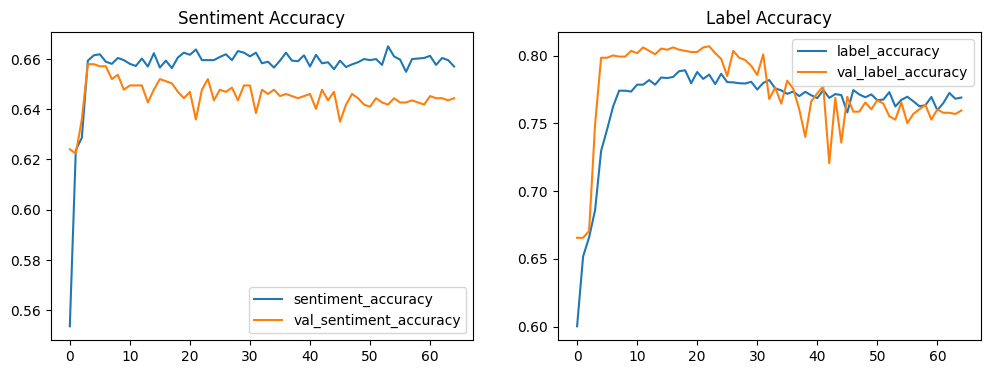

time: 433 ms (started: 2025-01-28 10:44:01 +00:00)


In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sentiment_accuracy'], label='sentiment_accuracy')
plt.plot(history.history['val_sentiment_accuracy'], label='val_sentiment_accuracy')
plt.title('Sentiment Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['label_accuracy'], label='label_accuracy')
plt.plot(history.history['val_label_accuracy'], label='val_label_accuracy')
plt.title('Label Accuracy')
plt.legend()
plt.show()

## Evaluate Model Performance

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.24      0.15      0.18       173
     neutral       0.48      0.39      0.43       271
    positive       0.74      0.85      0.79       737

    accuracy                           0.64      1181
   macro avg       0.48      0.46      0.47      1181
weighted avg       0.61      0.64      0.62      1181


Label Classification Report:
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00       166
         non       0.62      0.76      0.68       229
     trusted       0.81      0.93      0.87       786

    accuracy                           0.77      1181
   macro avg       0.48      0.56      0.52      1181
weighted avg       0.66      0.77      0.71      1181



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


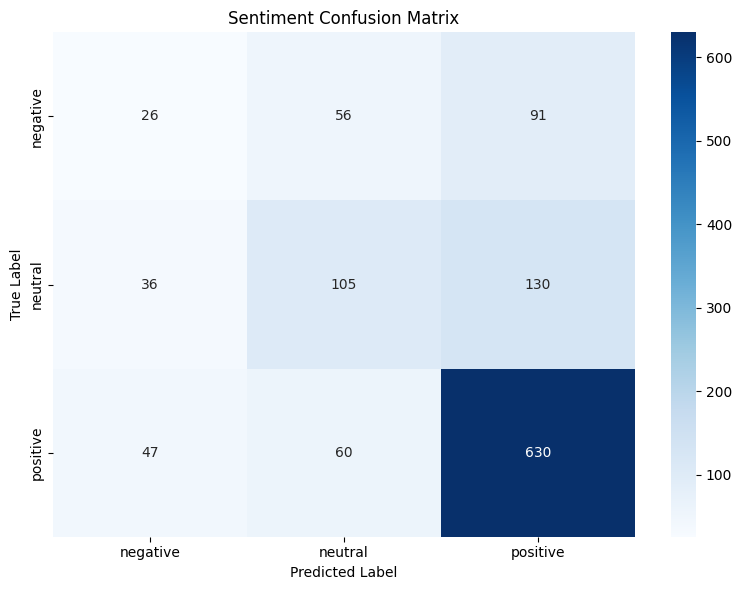

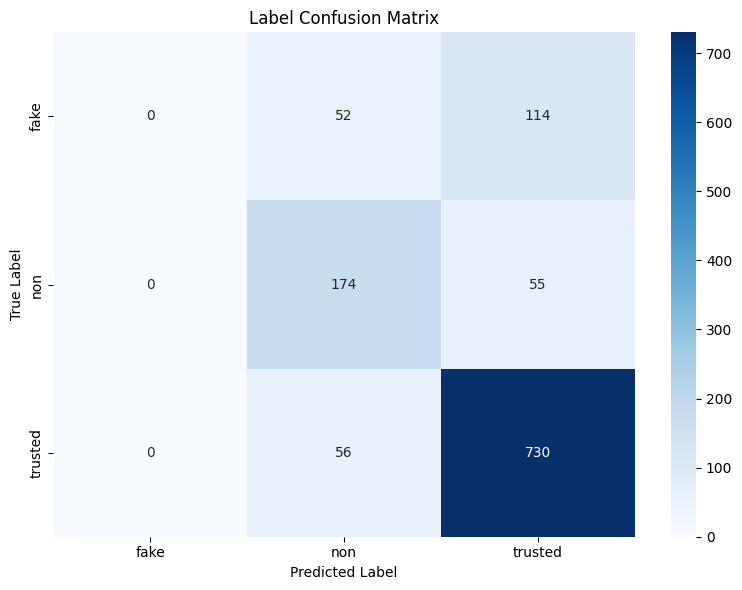

time: 1.13 s (started: 2025-01-28 10:44:02 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
evaluation_metrics = evaluate_model(model, X_test, y_sentiment_test, y_label_test, 
                                  sentiment_encoder, label_encoder)

## Try Predictions

In [14]:
text = "Sayangnya pengiriman lebih lambat dari jadwal. Produk tetap sampai dengan baik, tetapi semoga pengiriman bisa lebih cepat di masa depan."
sentiment, label = predict_text(
    text,
    model,
    tokenizer,
    sentiment_encoder,
    label_encoder,
    max_len
)
print(f"Sentiment: {sentiment}")
print(f"Label: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sentiment: neutral
Label: non
time: 65 ms (started: 2025-01-28 10:49:45 +00:00)


# WordCloud

## Positive

In [17]:
df_reviews.head(1)

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ?2 tahun, te...","Waktu smp aku pakai ss ini selama ? tahun, ter...",Waktu smp aku pakai ss ini selama tahun ter...,Waktu smp aku pakai ss ini selama tahun terus ...,waktu smp aku pakai ss ini selama tahun terus ...,"['waktu', 'smp', 'aku', 'pakai', 'ss', 'ini', ...","['smp', 'pakai', 'stop', 'covid', 'pas', 'coba...","['smp', 'pakai', 'stop', 'covid', 'pas', 'coba...","[smp, pakai, stop, covid, pas, coba, pake, bre..."


time: 11.5 ms (started: 2025-01-28 11:06:29 +00:00)


6231


Text(0.5, 1.0, '\nPOSITIVE\n')

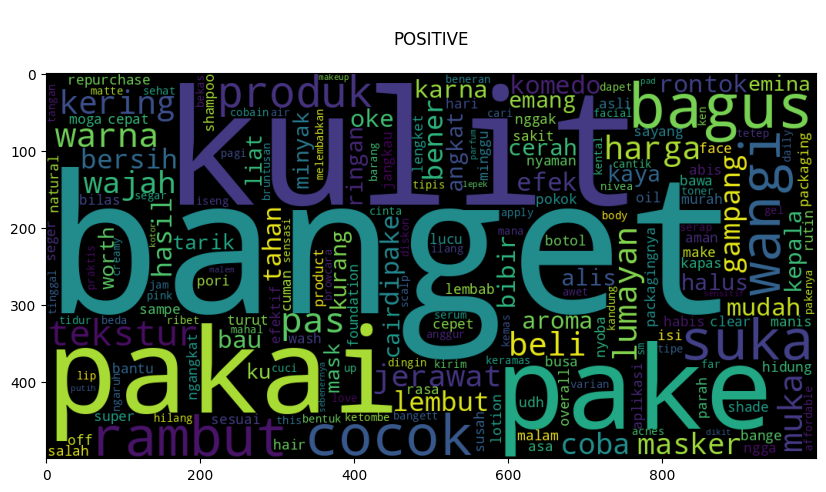

time: 1.26 s (started: 2025-01-28 11:09:57 +00:00)


In [28]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='positive']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nPOSITIVE\n')

## Neutral

3469


Text(0.5, 1.0, '\nNEUTRAL\n')

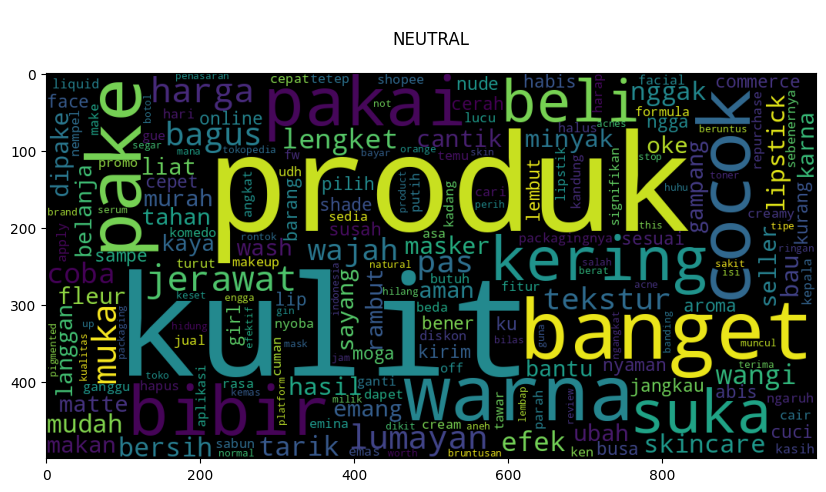

time: 1.28 s (started: 2025-01-28 11:11:51 +00:00)


In [32]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='neutral']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEUTRAL\n')

## Negative

2733


Text(0.5, 1.0, '\nNEGATIVE\n')

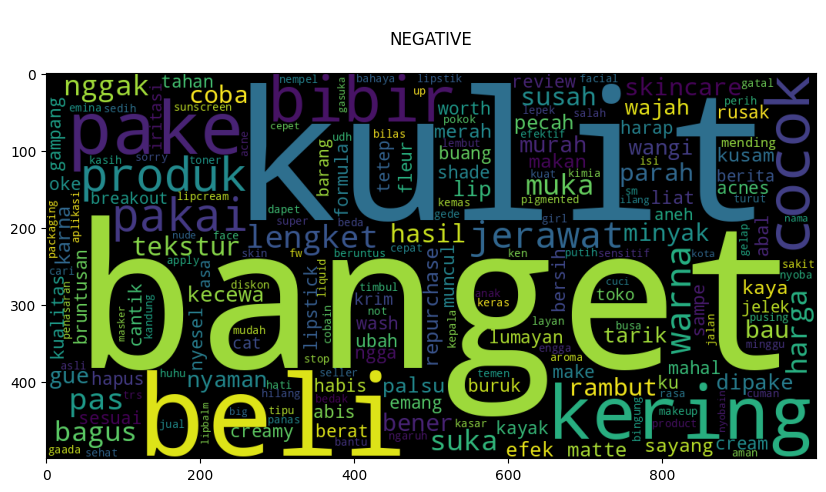

time: 1.23 s (started: 2025-01-28 11:12:33 +00:00)


In [34]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='negative']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEGATIVE\n')

In [35]:
df_reviews.label.unique()

array(['trusted', 'fake', 'non'], dtype=object)

time: 2.82 ms (started: 2025-01-28 11:13:57 +00:00)


## Trusted

6857


Text(0.5, 1.0, '\nTRUSTED\n')

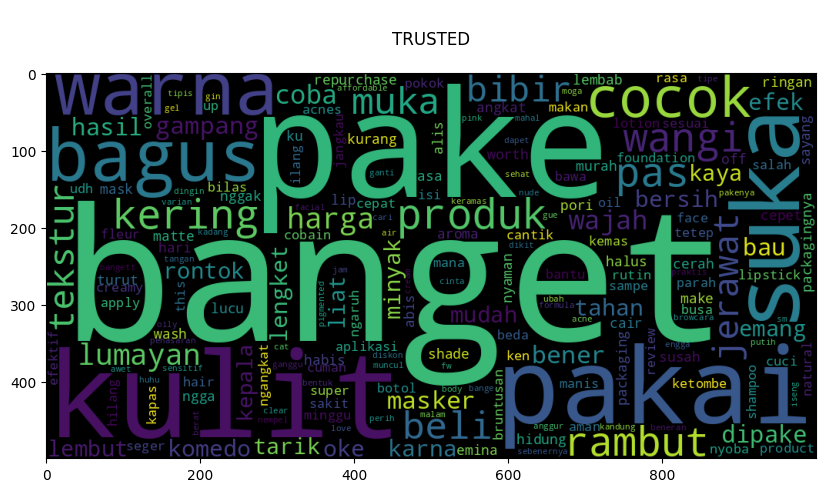

time: 1.24 s (started: 2025-01-28 11:14:38 +00:00)


In [37]:
word_list = []
for text in df_reviews[df_reviews['label']=='trusted']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nTRUSTED\n')

## Non

2540


Text(0.5, 1.0, '\nNON\n')

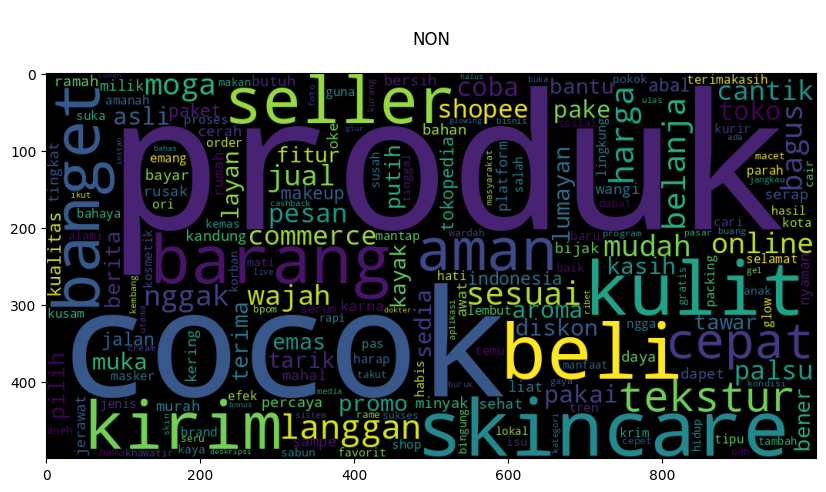

time: 1.21 s (started: 2025-01-28 11:15:39 +00:00)


In [38]:
word_list = []
for text in df_reviews[df_reviews['label']=='non']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')

## Fake

1618


Text(0.5, 1.0, '\nNON\n')

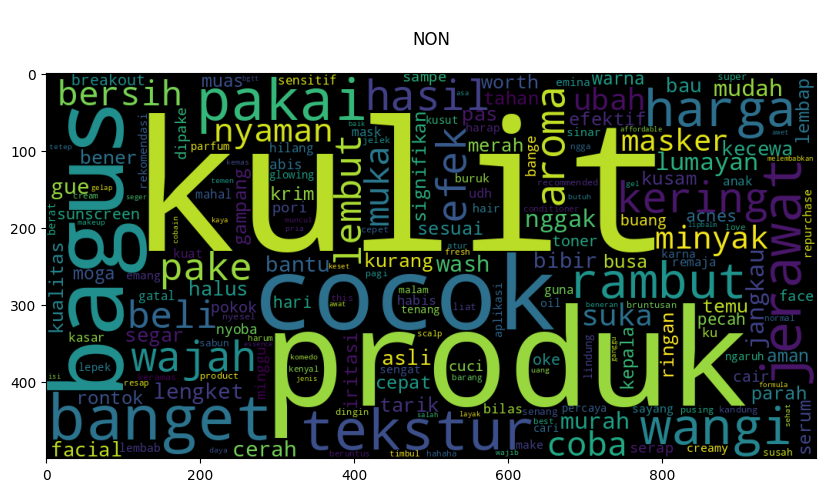

time: 1.17 s (started: 2025-01-28 11:16:08 +00:00)


In [39]:
word_list = []
for text in df_reviews[df_reviews['label']=='fake']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')